<Strong> Note to the reader: </Strong> This notebook currently calculates the Auto count-count correlations of the PanSTARRS data and CMASS/LOWZ data. See notes on fixes and future things./br>

-MT 5/14/20 9am

#### List of changes/fixes that are not resolved: 

- Data for panstarrs is outside the pointing? --- NEED TO INVESTIGATE 
- Corr func asymptotes to .2 instead of zero? Ross: Look as CMASS and LOWZ auto corr to check for zero corr function. --- NEED TO DO 
- Check papers for plots to compare --- NEED TO FINISH
- Theory calculuation for CMASS plots --- COULD DO 

### Imports and formatting: 

In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import treecorr
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

### Define notebook wide functions and data paths to use:

In [3]:
dataPath = '/Users/megantabbutt/CosmologyDataProducts/'


 <hr style="height:3px"> 


## 0. Pull in and parse data:

note: There are 10 pointings for the PanSTARRS data, we will use all 10 for the Auto Correlation, but when we correlated to CMASS, we need to only use the 9 overlap with CMASS. --- IMPORTANT

#### PanSTARRS: 

In [4]:
connPAN = sqlite3.connect(dataPath + 'PanSTARRS.db')

qry = "SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (zSN > -999) || (zHost > -999)"

PanSTARRSNEW_GoodZ = pd.read_sql(qry, con=connPAN)
PanSTARRSNEW_GoodZ.head(3) # 1129 objects over 10 pointings 

,ID,DEC,RA,zSN,zHost
0,ps0909006,1.184831,333.9500,0.284,-999.0
1,ps0909010,-4.078911,37.1182,0.270,-999.0
2,ps0910017,-5.023289,35.2775,0.320,-999.0


#### CMASS/LOWZ:

In [5]:
# Open a SQL connection to union the four CMASS/LOWZ data sets together: 

connBOSS = sqlite3.connect(dataPath + 'CMASS_and_LOWZ.db')

qry = "SELECT * FROM CMASSLOWZTOT_South UNION SELECT * FROM CMASSLOWZTOT_North"

CMASSLOWZTOT_DF = pd.read_sql(qry, con=connBOSS)
CMASSLOWZTOT_DF.head(3) # 1.3 million objects

,index,RA,DEC,Z,NZ
0,0,195.071285,-0.590771,0.465648,0.000345
1,0,321.480329,9.973440,0.301401,0.000390
2,1,195.022992,-0.610999,0.565802,0.000319


#### Pull in the Randoms provided by CMASS:

In [6]:
connBOSSRands = sqlite3.connect(dataPath + 'CMASS_and_LOWZ_rands.db')
randSampleQry = "SELECT * FROM CMASSLOWZTOT_South_rands WHERE `index` IN (SELECT `index` FROM CMASSLOWZTOT_South_rands ORDER BY RANDOM() LIMIT 50000) UNION SELECT * FROM CMASSLOWZTOT_North_rands WHERE `index` IN (SELECT `index` FROM CMASSLOWZTOT_North_rands ORDER BY RANDOM() LIMIT 50000)"
randQry = "SELECT * FROM CMASSLOWZTOT_South_rands UNION SELECT * FROM CMASSLOWZTOT_North_rands"

CMASSLOWZTOT_DF_rands = pd.read_sql(randSampleQry, con=connBOSSRands)
CMASSLOWZTOT_DF_rands.to_json(dataPath + "CMASSLOWZTOT_DF_rands")
CMASSLOWZTOT_DF_rands.head(3)

,index,RA,DEC,Z,NZ
0,313,184.600746,23.219418,0.543312,0.000369
1,340,201.832233,25.474612,0.505383,0.000434
2,496,31.878872,-2.166361,0.132041,0.000846


In [7]:
connBOSS.close()
connBOSSRands.close()

## ^ ^ ^ ^ DONT FORGET TO CHANGE ME BACK for HEP!!!!

 <hr style="height:3px"> 

## 1. Create the TreeCorr Catalogs of Data:

In [8]:
catPanSTARRS = treecorr.Catalog(ra=PanSTARRSNEW_GoodZ['RA'], dec=PanSTARRSNEW_GoodZ['DEC'], ra_units='degrees', dec_units='degrees')
catPanSTARRS

Catalog(x=array([ 0.89821907,  0.79537251,  0.81322895, ..., -0.44845015,
       -0.86674663, -0.46424765]),y=array([-0.43906143,  0.60193276,  0.57531887, ...,  0.53951108,
        0.49764081,  0.55135371]),z=array([ 0.02067772, -0.07113031, -0.08756066, ...,  0.71261508,
        0.033225  ,  0.69316896]),ra=array([5.82852704, 0.6478348 , 0.61570853, ..., 2.26428363, 2.62039894,
       2.2706359 ]),dec=array([ 0.02067919, -0.07119043, -0.08767293, ...,  0.79321874,
        0.03323112,  0.76587641]),w=array([1., 1., 1., ..., 1., 1., 1.]))

### Count-Count Correlation Function: 

In [9]:
# Data Auto-correlation: (dd)
ddPanSTARRS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
ddPanSTARRS.process(catPanSTARRS)

### 1.5 Create the randoms with PanSTARRS since no mask yet
Include all ten pointings for now, can redo when we are going to crossCorr with CMASS

In [10]:
# Change this for HEP for more rands 
randsLength = 10**5

ra_min_PanSTARRS = numpy.min(catPanSTARRS.ra)
ra_max_PanSTARRS = numpy.max(catPanSTARRS.ra)
dec_min_PanSTARRS = numpy.min(catPanSTARRS.dec)
dec_max_PanSTARRS = numpy.max(catPanSTARRS.dec)
print('PanSTARRS ra range = %f .. %f' % (ra_min_PanSTARRS, ra_max_PanSTARRS))
print('PanSTARRS dec range = %f .. %f' % (dec_min_PanSTARRS, dec_max_PanSTARRS))

rand_ra_PanSTARRS = numpy.random.uniform(ra_min_PanSTARRS, ra_max_PanSTARRS, randsLength)
rand_sindec_PanSTARRS = numpy.random.uniform(numpy.sin(dec_min_PanSTARRS), numpy.sin(dec_max_PanSTARRS), randsLength)
rand_dec_PanSTARRS = numpy.arcsin(rand_sindec_PanSTARRS)

PanSTARRS ra range = 0.600713 .. 6.172202
PanSTARRS dec range = -0.506386 .. 1.038391


## ^ ^ ^ ^ DONT FORGET TO CHANGE ME BACK for HEP!!!!

In [11]:
# MD02 is the one that needs to be eliminated, not in CMASS footprint 

pointings = {"MD01": [035.875, -04.250], "MD03": [130.592, 44.317], "MD04": [150.000, 02.200], 
             "MD05": [161.917, 58.083], "MD06": [185.000, 47.117], "MD07": [213.704, 53.083], 
             "MD08": [242.787, 54.950], "MD09": [334.188, 00.283], "MD10": [352.312, -00.433], "MD02": [053.100, -27.800],}

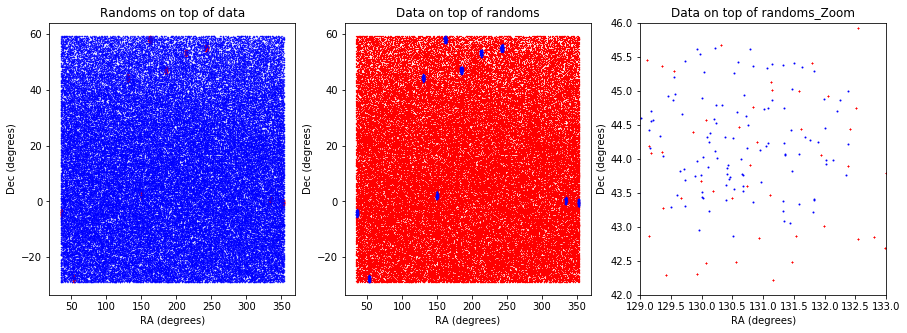

In [12]:
# Takes forever 
# Check that the randoms cover the same space as the data

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='red', s=0.1, marker='x')
ax1.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='blue', s=0.1)
ax1.set_xlabel('RA (degrees)')
ax1.set_ylabel('Dec (degrees)')
ax1.set_title('Randoms on top of data')

# Repeat in the opposite order
ax2.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='red', s=0.1, marker='x')
ax2.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='blue', s=0.1)
ax2.set_xlabel('RA (degrees)')
ax2.set_ylabel('Dec (degrees)')
ax2.set_title('Data on top of randoms')

# Zoom to look at coverage of randoms and reals
ax3.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='red', s=1, marker='x')
ax3.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='blue', s=1)
ax3.set_xlabel('RA (degrees)')
ax3.set_ylabel('Dec (degrees)')
ax3.set_title('Data on top of randoms_Zoom')
ax3.set_xlim(129, 133)
ax3.set_ylim(42, 46)

plt.show()

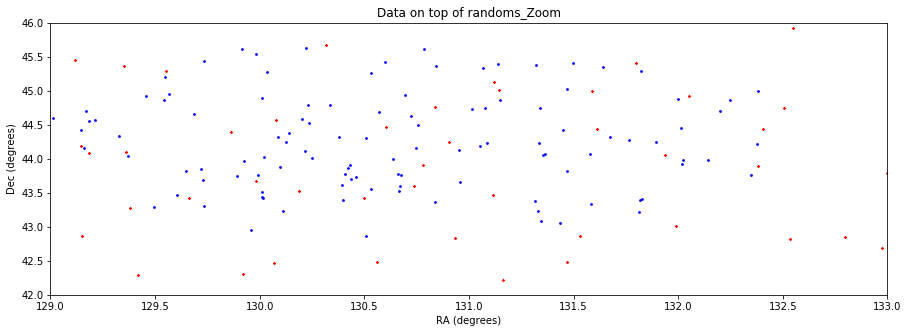

In [13]:
# Check that the randoms cover the same space as the data, this takes a while, skip if confident

f, (ax3) = plt.subplots(1, 1, figsize=(15,5))

# Zoom to look at coverage of randoms and reals
ax3.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='red', s=3, marker='x')
ax3.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='blue', s=3)
ax3.set_xlabel('RA (degrees)')
ax3.set_ylabel('Dec (degrees)')
ax3.set_title('Data on top of randoms_Zoom')
ax3.set_xlim(129, 133)
ax3.set_ylim(42, 46)

plt.show()

In [14]:
rand_ra_PanSTARRS.min()

0.6008251117366716

In [15]:
maskRA = []
maskDEC = []

for pointing in pointings: 
    maskRAprevious = len(maskRA)
    X0 = pointings[pointing][0]
    Y0 = pointings[pointing][1]
    rad = 3.3/2
    print(pointings[pointing])
    
    for i in range(len(rand_ra_PanSTARRS)):
        #print(rand_ra_PanSTARRS[i], rand_dec_PanSTARRS[i])
        X = rand_ra_PanSTARRS[i] * 180 / numpy.pi
        Y = rand_dec_PanSTARRS[i] * 180 / numpy.pi
        
        if ((X - X0)**2 + (Y - Y0)**2 < rad**2):
            maskRA.append(X)
            maskDEC.append(Y)
    print(len(maskRA) - maskRAprevious)

[35.875, -4.25]
28
[130.592, 44.317]
27
[150.0, 2.2]
32
[161.917, 58.083]
21
[185.0, 47.117]
25
[213.704, 53.083]
22
[242.787, 54.95]
19
[334.188, 0.283]
38
[352.312, -0.433]
33
[53.1, -27.8]
23


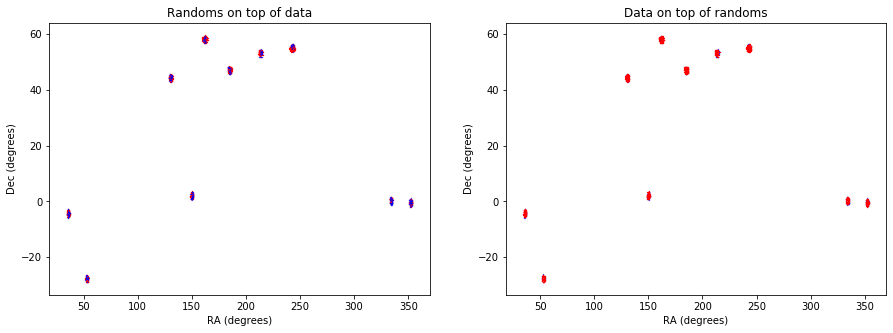

In [16]:
# Check that the randoms cover the same space as the data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='red', s=0.1, marker='x')
ax1.scatter(maskRA, maskDEC, color='blue', s=0.1)
ax1.set_xlabel('RA (degrees)')
ax1.set_ylabel('Dec (degrees)')
ax1.set_title('Randoms on top of data')

# Repeat in the opposite order
ax2.scatter(maskRA, maskDEC, color='blue', s=0.1)
ax2.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='red', s=0.1, marker='x')
ax2.set_xlabel('RA (degrees)')
ax2.set_ylabel('Dec (degrees)')
ax2.set_title('Data on top of randoms')

plt.show()

In [17]:
rand = treecorr.Catalog(ra=maskRA, dec=maskDEC, ra_units='degrees', dec_units='degrees')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
rr.process(rand)

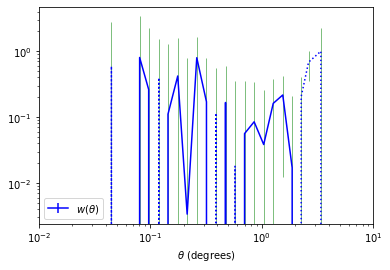

In [18]:
xi, varxi = ddPanSTARRS.calculateXi(rr)

r = numpy.exp(ddPanSTARRS.meanlogr)
sig = numpy.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='green', lw=0.5, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='green', lw=0.5, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.show()

In [19]:
dr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
dr.process(catPanSTARRS, rand)

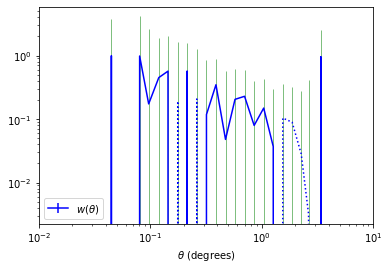

In [20]:
xi, varxi = ddPanSTARRS.calculateXi(rr, dr)
sig = numpy.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='green', lw=0.5, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='green', lw=0.5, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.show()

## 2.  CMASS Count-Count Auto Correlation Function:

In [21]:
catCMASS = treecorr.Catalog(ra=CMASSLOWZTOT_DF['RA'], dec=CMASSLOWZTOT_DF['DEC'], 
                                ra_units='degrees', dec_units='degrees')
catCMASS

Catalog(x=array([-0.96555174,  0.77057095, -0.96576697, ..., -0.75908709,
       -0.75899836, -0.75843631]),y=array([-0.26000679, -0.61337188, -0.25919189, ..., -0.07245224,
       -0.07669372, -0.07611541]),z=array([-0.01031072,  0.17319164, -0.01066374, ...,  0.64694471,
        0.64655979,  0.64728727]),ra=array([3.4046362 , 5.61089021, 3.40379332, ..., 3.23675093, 3.2422968 ,
       3.24161609]),dec=array([-0.0103109 ,  0.17406936, -0.01066394, ...,  0.70357085,
        0.70306617,  0.70402018]),w=array([1., 1., 1., ..., 1., 1., 1.]))

In [22]:
# Data Auto-correlation: (dd)
ddCMASS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
ddCMASS.process(catCMASS)

In [23]:
CMASSLOWZTOT_DF_rands.head(3)

,index,RA,DEC,Z,NZ
0,313,184.600746,23.219418,0.543312,0.000369
1,340,201.832233,25.474612,0.505383,0.000434
2,496,31.878872,-2.166361,0.132041,0.000846


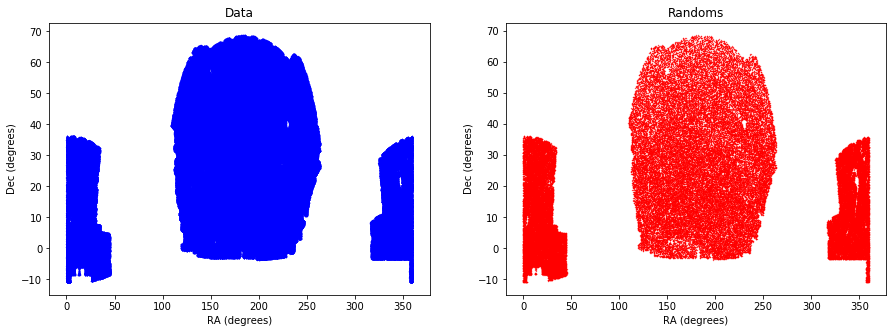

In [24]:
# Check that the randoms cover the same space as the data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.scatter(catCMASS.ra * 180/numpy.pi, catCMASS.dec * 180/numpy.pi, color='blue', s=0.1)
ax1.set_xlabel('RA (degrees)')
ax1.set_ylabel('Dec (degrees)')
ax1.set_title('Data')

# Repeat in the opposite order
ax2.scatter(CMASSLOWZTOT_DF_rands['RA'], CMASSLOWZTOT_DF_rands['DEC'], color='red', s=0.1)
ax2.set_xlabel('RA (degrees)')
ax2.set_ylabel('Dec (degrees)')
ax2.set_title('Randoms')

plt.show()

In [25]:
randCMASS = treecorr.Catalog(ra=CMASSLOWZTOT_DF_rands['RA'], dec=CMASSLOWZTOT_DF_rands['DEC'], ra_units='degrees', dec_units='degrees')
rrCMASS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
rrCMASS.process(randCMASS)

In [26]:
drCMASS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
drCMASS.process(catCMASS, randCMASS)

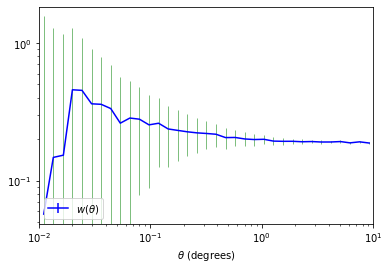

In [27]:
rCMASS = numpy.exp(ddCMASS.meanlogr)
xiCMASS, varxiCMASS = ddCMASS.calculateXi(rrCMASS, drCMASS)
sigCMASS = numpy.sqrt(varxiCMASS)

plt.plot(rCMASS, xiCMASS, color='blue')
plt.plot(rCMASS, -xiCMASS, color='blue', ls=':')
plt.errorbar(rCMASS[xiCMASS>0], xiCMASS[xiCMASS>0], yerr=sigCMASS[xiCMASS>0], color='green', lw=0.5, ls='')
plt.errorbar(rCMASS[xiCMASS<0], -xiCMASS[xiCMASS<0], yerr=sigCMASS[xiCMASS<0], color='green', lw=0.5, ls='')
leg = plt.errorbar(-rCMASS, xiCMASS, yerr=sigCMASS, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.show()

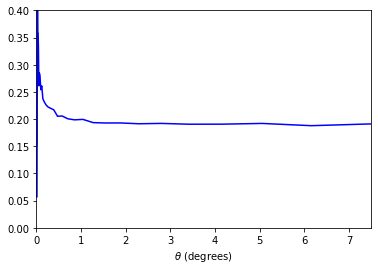

In [28]:
rCMASS = numpy.exp(ddCMASS.meanlogr)
xiCMASS, varxiCMASS = ddCMASS.calculateXi(rrCMASS, drCMASS)
sigCMASS = numpy.sqrt(varxiCMASS)

plt.plot(rCMASS, xiCMASS, color='blue')
plt.plot(rCMASS, -xiCMASS, color='blue', ls=':')
#plt.errorbar(rCMASS[xiCMASS>0], xiCMASS[xiCMASS>0], yerr=sigCMASS[xiCMASS>0], color='green', lw=0.5, ls='')
#plt.errorbar(rCMASS[xiCMASS<0], -xiCMASS[xiCMASS<0], yerr=sigCMASS[xiCMASS<0], color='green', lw=0.5, ls='')
#leg = plt.errorbar(-rCMASS, xiCMASS, yerr=sigCMASS, color='blue')

#plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

#plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.0, 7.5])
plt.ylim([0.0, .4])
plt.show()